<img src="gwfish_priors_white.png" width="300" height="300">

# Adding Priors

In Bayesian analysis, we start with prior beliefs about the parameters of the source, which represent our initial knowledge or assumptions. These priors can be informed by astrophysical models, previous observations, or theoretical predictions. As we observe the gravitational wave signal, we update these beliefs using the likelihood function, which quantifies the probability of observing the data given the parameters. The result is the posterior distribution, which represents our updated knowledge about the parameters after considering the data.

One of the advantages of the Bayesian approach is its ability to incorporate prior information and quantify uncertainties in a rigorous way. By combining prior knowledge with the observed data, we can make more informed inferences about the properties of the gravitational wave source.

$$p(\vec{\theta}|s) \propto \pi(\vec{\theta}){\mathcal{L}}(s|\vec{\theta})$$

We will now incorporate prior information $\pi(\vec{\theta})$ on top of the Fisher likelihood, with a sampling procedure that stays computationally efficient.

### Disclaimer!
To prior package will be public soon on the `GWFish` github repo. In the meanwhile, you can get the necessary modules from the repo of the `GWFish+Priors` recent paper [arXiv:2404.16103](https://arxiv.org/abs/2404.16103)
```
git clone https://github.com/u-dupletsa/GWFish-meets-Priors
```
from the folder location execute the command
```
pip install .
```

In [37]:
import GWFish.priors_modules as gw_priors
import GWFish.modules as gw
import json
import os
import pandas as pd
import numpy as np

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize = 12) 
matplotlib.rc('ytick', labelsize = 12)

In [4]:
# Choose the number of samples
N = 10**4

In [30]:
# fisher parameters (all the injection parameters)
params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 
            'geocent_time', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']

# GW150914 signal as observed with LIGO (Hanford + Livingston)

In [32]:
inj_file = 'IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo_IMRPhenomXPHM_median.hdf5'
injections = pd.read_hdf('data' + '/' + inj_file)

In [40]:
name_tag = 'BBH_LVK'

detectors_ids = ['H1', 'L1']
ConfigDet = os.path.join('data' + '/' + 'IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.yaml')


network = gw.detection.Network(detectors_ids, detection_SNR=(0., 0.), config=ConfigDet)
gw.fishermatrix.analyze_and_save_to_txt(network = network,
                                parameter_values  = injections,
                                fisher_parameters = params, 
                                sub_network_ids_list = [[0, 1]],
                                population_name = name_tag,
                                waveform_model = 'IMRPhenomXPHM',
                                save_path = 'gwfish_results',
                                save_matrices = True,
                                decimal_output_format='%.15f')

100%|██████████| 1/1 [00:17<00:00, 17.03s/it]


In [41]:
mns = injections.iloc[0].to_numpy()

In [42]:
cov_lvk = np.load('gwfish_results' + '/' + 'inv_fisher_matrices_H1_L1_BBH_LVK_SNR0.npy')[0, :, :]

### Samples from `GWFish`

In [43]:
samples_lvk = np.random.multivariate_normal(mns, cov_lvk, N)
samples_lvk = pd.DataFrame(samples_lvk, columns=params)

## Add Priors

In [44]:
priors_dict = {
        'chirp_mass': np.array([15, 45]),
        'mass_ratio': np.array([0.05, 1.0]),
        'luminosity_distance': np.array([10, 10000]),
        'dec': np.array([-np.pi/2, np.pi/2]),
        'ra': np.array([0, 2*np.pi]),
        'theta_jn': np.array([0, np.pi]),
        'psi': np.array([0, np.pi]),
        'phase': np.array([0, 2*np.pi]),
        'geocent_time': np.array([float(injections['geocent_time'][0] - 0.5), float(injections['geocent_time'][0] + 0.5)]),
        'a_1': np.array([0, 0.99]),
        'a_2': np.array([0, 0.99]),
        'tilt_1': np.array([0, np.pi]),
        'tilt_2': np.array([0, np.pi]),
        'phi_12': np.array([0, 2*np.pi]),
        'phi_jl': np.array([0, 2*np.pi])
    }

## Minimax tilting sampling from truncated Gaussian [see Botev 2016]
1. Identify target distribution for which direct sampling might be problematic (multi-dimensional truncated Gaussian)
2. Choose a family of tilting distributions that are easier to samples from (Gaussians in our case with adjustable parameters)
3. Choose best tilting parameters so that the maximum distance (the Kullback-Leibler (KL) divergence) between the auxiliar and the target distribution is minimized (hence *minimax*)
4. Sample from tilted distribution
5. Re-weight samples to match the target distribution

In [45]:
min_array = np.array([-np.inf, 0, 0, -np.pi/2, 0, 0, 0, 0, -np.inf, 0, 0, 0, 0, 0, 0])
max_array = np.array([np.inf, 1, 20000, np.pi/2, 2*np.pi, np.pi, np.pi, 2*np.pi, np.inf, 1, 1, np.pi, np.pi, 2*np.pi, 2*np.pi])

In [46]:
tmvn_lvk = gw_priors.minimax_tilting_sampler.TruncatedMVN(mns, cov_lvk, min_array, max_array)
samples_tmvn_lvk = tmvn_lvk.sample(N)
samples_lvk_trunc = pd.DataFrame(samples_tmvn_lvk.T, columns = params)

Re-weight samples from the truncated multi-variate Gaussian based on prior value

In [48]:
samples_lvk_trunc['priors'] = gw_priors.priors.uniform_pdf(samples_lvk_trunc['chirp_mass'].to_numpy(), priors_dict['chirp_mass'][0], priors_dict['chirp_mass'][1])*\
                    gw_priors.priors.uniform_pdf(samples_lvk_trunc['mass_ratio'].to_numpy(), priors_dict['mass_ratio'][0], priors_dict['mass_ratio'][1])*\
                    gw_priors.priors.uniform_in_distance_squared_pdf(samples_lvk_trunc['luminosity_distance'].to_numpy(), priors_dict['luminosity_distance'][0], priors_dict['luminosity_distance'][1])*\
                    gw_priors.priors.cosine_pdf(samples_lvk_trunc['dec'].to_numpy(), priors_dict['dec'][0], priors_dict['dec'][1])*\
                    gw_priors.priors.uniform_pdf(samples_lvk_trunc['ra'].to_numpy(), priors_dict['ra'][0], priors_dict['ra'][1])*\
                    gw_priors.priors.sine_pdf(samples_lvk_trunc['theta_jn'].to_numpy(), priors_dict['theta_jn'][0], priors_dict['theta_jn'][1])*\
                    gw_priors.priors.uniform_pdf(samples_lvk_trunc['psi'].to_numpy(), priors_dict['psi'][0], priors_dict['psi'][1])*\
                    gw_priors.priors.uniform_pdf(samples_lvk_trunc['phase'].to_numpy(), priors_dict['phase'][0], priors_dict['phase'][1])*\
                    gw_priors.priors.uniform_pdf(samples_lvk_trunc['geocent_time'].to_numpy(), priors_dict['geocent_time'][0], priors_dict['geocent_time'][1])*\
                    gw_priors.priors.uniform_pdf(samples_lvk_trunc['a_1'].to_numpy(), priors_dict['a_1'][0], priors_dict['a_1'][1])*\
                    gw_priors.priors.uniform_pdf(samples_lvk_trunc['a_2'].to_numpy(), priors_dict['a_2'][0], priors_dict['a_2'][1])*\
                    gw_priors.priors.sine_pdf(samples_lvk_trunc['tilt_1'].to_numpy(), priors_dict['tilt_1'][0], priors_dict['tilt_1'][1])*\
                    gw_priors.priors.sine_pdf(samples_lvk_trunc['tilt_2'].to_numpy(), priors_dict['tilt_2'][0], priors_dict['tilt_2'][1])*\
                    gw_priors.priors.uniform_pdf(samples_lvk_trunc['phi_12'].to_numpy(), priors_dict['phi_12'][0], priors_dict['phi_12'][1])*\
                    gw_priors.priors.uniform_pdf(samples_lvk_trunc['phi_jl'].to_numpy(), priors_dict['phi_jl'][0], priors_dict['phi_jl'][1])
    
samples_lvk_trunc['weights'] = samples_lvk_trunc['priors'] / np.sum(samples_lvk_trunc['priors'])
prob_lvk = samples_lvk_trunc['weights'].to_numpy()
index_lvk = np.random.choice(np.arange(N), size = N, replace = True, p = prob_lvk)
posteriors_lvk = samples_lvk_trunc.iloc[index_lvk]
posteriors_lvk = pd.DataFrame(posteriors_lvk, columns = params)

In [49]:
my_palette1 = [(0.6509803921568628, 0.807843137254902, 0.8901960784313725), (0.12156862745098039, 0.47058823529411764, 0.7058823529411765)]
my_palette2 = [(0.9921568627450981, 0.7490196078431373, 0.43529411764705883), (1.0, 0.4980392156862745, 0.0)]

In [50]:
param_label = {'chirp_mass': r'$\mathcal{M}_c$', 'mass_ratio': r'$q$', 'luminosity_distance': r'$d_L$',
                'dec': r'$DEC$', 'ra': r'$RA$', 'theta_jn': r'$\theta_{JN}$', 'psi': r'$\Psi$',
                'phase': r'$\phi$', 'geocent_time': r'$t_c$', 'a_1': r'$a_1$', 'a_2': r'$a_2$',
                'tilt_1': r'$tilt_1$', 'tilt_2': r'$tilt_2$', 'phi_12': r'$phi_{12}$',
                'phi_jl': r'$phi_{JL}$'}

In [51]:
param_unit = {'chirp_mass': r'[$M_{\odot}$]', 'mass_ratio': r'', 'luminosity_distance': r'[Mpc]',
                'dec': r'[rad]', 'ra': r'[rad]', 'theta_jn': r'[rad]', 'psi': r'[rad]',
                'phase': r'[rad]', 'geocent_time': r'[s]', 'a_1': r'', 'a_2': r'',
                'tilt_1': r'[rad]', 'tilt_2': r'[rad]', 'phi_12': r'[rad]',
                'phi_jl': r'[rad]'}

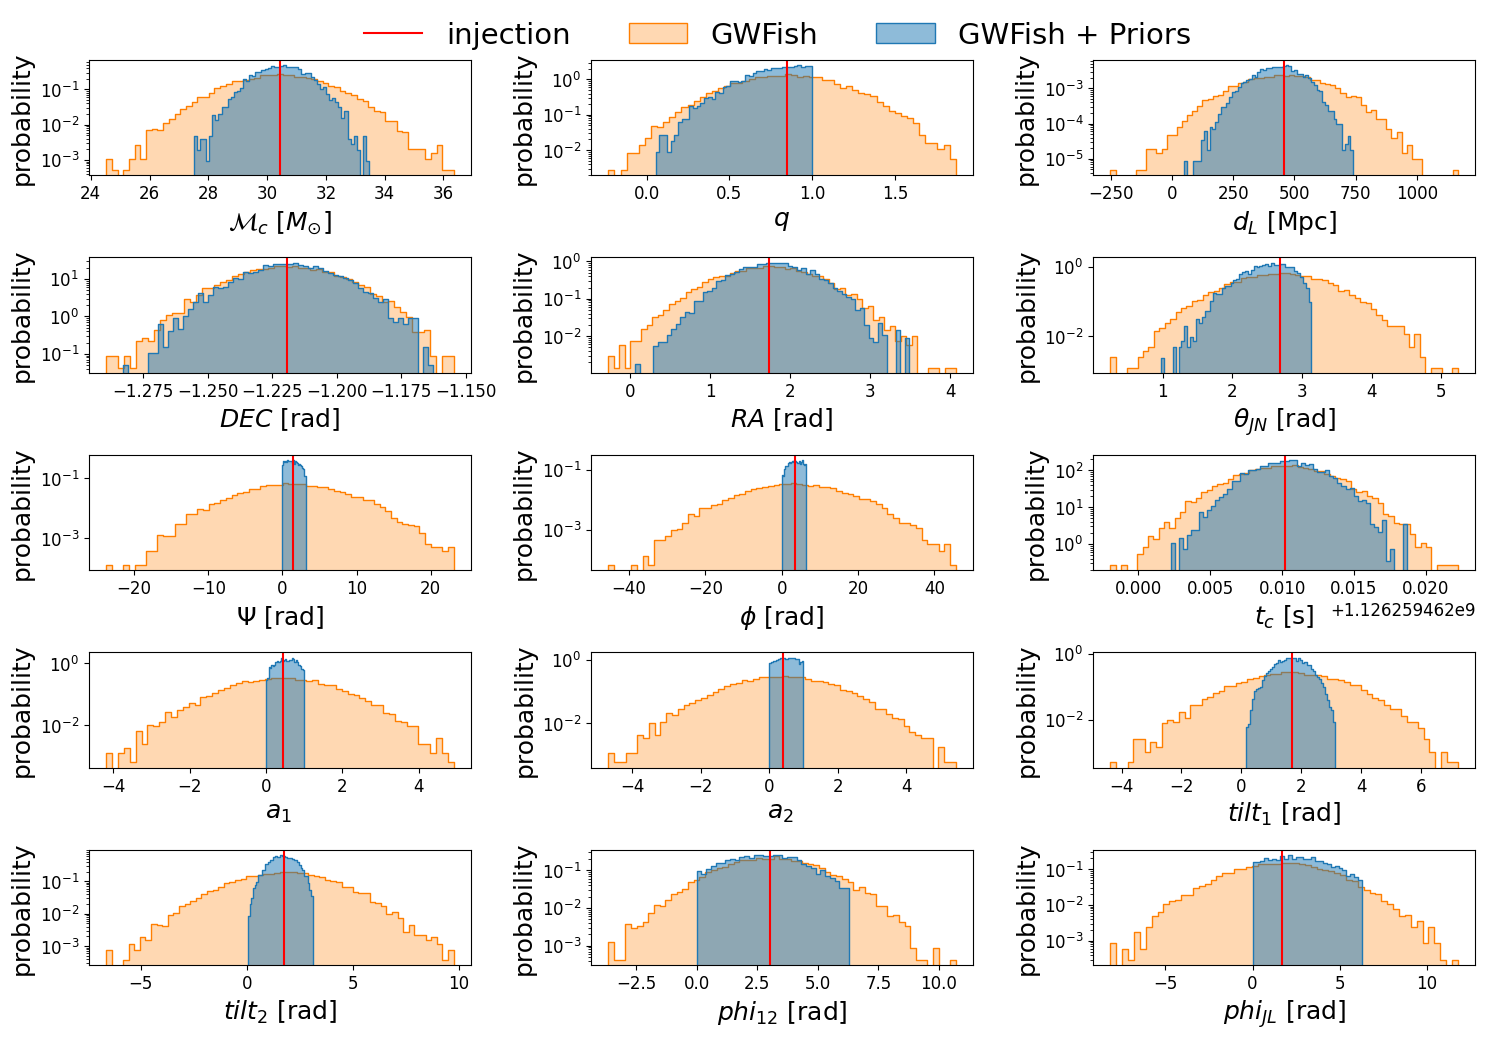

In [52]:
fig, axs = plt.subplots(5, 3, figsize=(15, 10))
#fig.suptitle(r'$\texttt{GW150914}$', fontsize=20)

for i, param in enumerate(params):
    ax = axs[i//3, i%3]
    ax.axvline(injections[param].values[0], color='red', label = 'injection', linewidth=1.5)
    ax = sns.histplot(samples_lvk[param], stat='density', element='step', 
                    ax=ax, label='Fisher', alpha = 0.3, color = my_palette2[1], linewidth=1.)
    ax = sns.histplot(posteriors_lvk[param], stat='density', element='step', 
                    ax=ax, label='Fisher + Priors', alpha=0.5, color = my_palette1[1], linewidth=1.)
    
    ax.set_ylabel('probability', fontsize=18)
    ax.set_xlabel('%s %s' %(param_label[param], param_unit[param]), fontsize=18)
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

fig.legend(labels=['injection', 'GWFish', 'GWFish + Priors'], fontsize=21, bbox_to_anchor=(0.815,1.05), ncol = 4, frameon=False)
fig.tight_layout()
plt.show()

## Einstein Telescope

In [35]:
cov = np.load('gwfish_results' + '/' + 'inv_fisher_matrices.npy')[0, :, :]

In [36]:
gwfish_samples = np.random.multivariate_normal(mns, cov, N)
gwfish_samples = pd.DataFrame(gwfish_samples, columns=params)

In [11]:
tmvn = gw_priors.minimax_tilting_sampler.TruncatedMVN(mns, cov, min_array, max_array)
samples_tmvn = tmvn.sample(N)
samples = pd.DataFrame(samples_tmvn.T, columns = params)

In [18]:
samples['priors'] = gw_priors.priors.uniform_pdf(samples['chirp_mass'].to_numpy(), priors_dict['chirp_mass'][0], priors_dict['chirp_mass'][1])*\
                    gw_priors.priors.uniform_pdf(samples['mass_ratio'].to_numpy(), priors_dict['mass_ratio'][0], priors_dict['mass_ratio'][1])*\
                    gw_priors.priors.uniform_in_distance_squared_pdf(samples['luminosity_distance'].to_numpy(), priors_dict['luminosity_distance'][0], priors_dict['luminosity_distance'][1])*\
                    gw_priors.priors.cosine_pdf(samples['dec'].to_numpy(), priors_dict['dec'][0], priors_dict['dec'][1])*\
                    gw_priors.priors.uniform_pdf(samples['ra'].to_numpy(), priors_dict['ra'][0], priors_dict['ra'][1])*\
                    gw_priors.priors.sine_pdf(samples['theta_jn'].to_numpy(), priors_dict['theta_jn'][0], priors_dict['theta_jn'][1])*\
                    gw_priors.priors.uniform_pdf(samples['psi'].to_numpy(), priors_dict['psi'][0], priors_dict['psi'][1])*\
                    gw_priors.priors.uniform_pdf(samples['phase'].to_numpy(), priors_dict['phase'][0], priors_dict['phase'][1])*\
                    gw_priors.priors.uniform_pdf(samples['geocent_time'].to_numpy(), priors_dict['geocent_time'][0], priors_dict['geocent_time'][1])*\
                    gw_priors.priors.uniform_pdf(samples['a_1'].to_numpy(), priors_dict['a_1'][0], priors_dict['a_1'][1])*\
                    gw_priors.priors.uniform_pdf(samples['a_2'].to_numpy(), priors_dict['a_2'][0], priors_dict['a_2'][1])*\
                    gw_priors.priors.sine_pdf(samples['tilt_1'].to_numpy(), priors_dict['tilt_1'][0], priors_dict['tilt_1'][1])*\
                    gw_priors.priors.sine_pdf(samples['tilt_2'].to_numpy(), priors_dict['tilt_2'][0], priors_dict['tilt_2'][1])*\
                    gw_priors.priors.uniform_pdf(samples['phi_12'].to_numpy(), priors_dict['phi_12'][0], priors_dict['phi_12'][1])*\
                    gw_priors.priors.uniform_pdf(samples['phi_jl'].to_numpy(), priors_dict['phi_jl'][0], priors_dict['phi_jl'][1])
    
samples['weights'] = samples['priors'] / np.sum(samples['priors'])
prob = samples['weights'].to_numpy()
index = np.random.choice(np.arange(N), size = N, replace = True, p = prob)
posteriors = samples.iloc[index]
posteriors = pd.DataFrame(posteriors, columns = params)

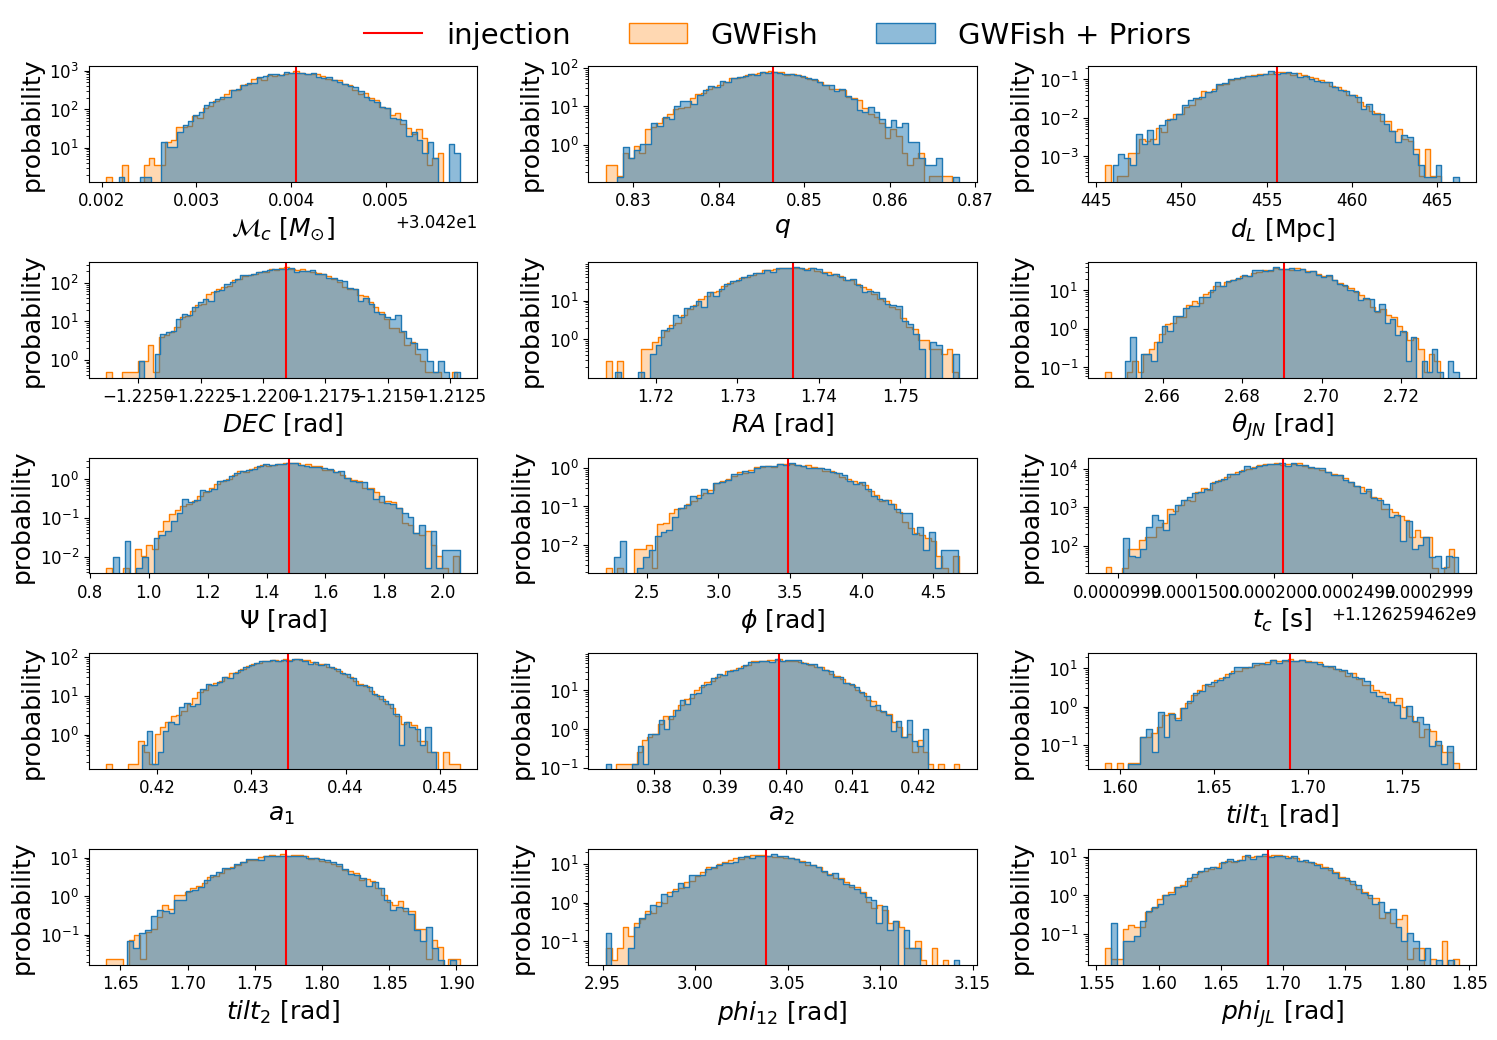

In [27]:
fig, axs = plt.subplots(5, 3, figsize=(15, 10))
#fig.suptitle(r'$\texttt{GW150914}$', fontsize=20)

for i, param in enumerate(params):
    ax = axs[i//3, i%3]
    ax.axvline(injections[param].values[0], color='red', label = 'injection', linewidth=1.5)
    ax = sns.histplot(gwfish_samples[param], stat='density', element='step', 
                    ax=ax, label='Fisher', alpha = 0.3, color = my_palette2[1], linewidth=1.)
    ax = sns.histplot(posteriors[param], stat='density', element='step', 
                    ax=ax, label='Fisher + Priors', alpha=0.5, color = my_palette1[1], linewidth=1.)
    
    ax.set_ylabel('probability', fontsize=18)
    ax.set_xlabel('%s %s' %(param_label[param], param_unit[param]), fontsize=18)
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

fig.legend(labels=['injection', 'GWFish', 'GWFish + Priors'], fontsize=21, bbox_to_anchor=(0.815,1.05), ncol = 4, frameon=False)
fig.tight_layout()
plt.show()